prepare NN architectures

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from joblib import load
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LSTM, Input
from keras.optimizers import Adam

def LSTM_(input_shape, **params):
    # Define the model
    model = Sequential()

    # Explicitly define the Input layer
    model.add(Input(shape=input_shape[0]))
    # Add an LSTM layer with dropout
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))  # Dropout of 20%
    # Add another LSTM layer with dropout
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))  # Dropout of 20%
    # Add a Dense layer with 'tanh' activation to output values between -1 and 1
    model.add(Dense(1, activation='tanh'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')   

    return model, {}

2024-11-05 14:55:07.876132: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "jax"
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# from collections import defaultdict
# from operator import itemgetter
from joblib import load
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import MultiHeadAttention, GlobalAveragePooling1D, Concatenate, LayerNormalization, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LSTM, BatchNormalization, AveragePooling1D, Input
from keras.optimizers import Adam
from keras_nlp.layers import SinePositionEncoding, TransformerEncoder
from keras.regularizers import l2

def Transformer1Input_(input_shape, **params):
    """
    - Neural network model for dual time series with varying sequence lengths and features.
    - Incorporates  TransformerEncoder layer
    - Applies Sine Positional Encoding for sequence order in both time series.
    - Final classification via dense layers with softmax activation.
    - Uses Adam optimizer and sparse categorical cross-entropy loss.
    - Adjustable for specific sequence lengths and data characteristics.

    """
    custom_layers = {}

    learning_rate = params.get("learning_rate", 0.001)
    #transformer layers for each input
    trans_layers = params.get("trans_layers", [1,1])
    l2_reg = params.get("l2_reg", 0.001)  # Added L2 regularization parameter

    input_ts1 = Input(shape=input_shape[0])  # Adjust sequence_length_1 as needed
    pos_encoding_1 = SinePositionEncoding()(input_ts1)
    x1 = pos_encoding_1 + input_ts1
    for _ in range(trans_layers[0]):
        x1 = TransformerEncoder(intermediate_dim=64, num_heads=5, dropout=0.2)(x1)
    x1 = GlobalAveragePooling1D()(x1)
    x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(x1)
    output = Dense(1, activation='tanh')(x)
    model = Model(inputs=[input_ts1], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    return model, custom_layers


Pipeline functions

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["KERAS_BACKEND"] = "jax"

class TransformerRollingWindowTrainer:
    def __init__(self, train_days=5, test_days=1, sequence_length=10):
        self.train_days = train_days
        self.test_days = test_days
        self.window_size = train_days + test_days
        self.sequence_length = sequence_length
        self.results = []
        
    def get_day_groups(self, df):
        """Group data by days using datetime index"""
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        return df.groupby(df.index.date)
    
    def prepare_sequences(self, data):
        """Prepare sequences for transformer model"""
        features = data.drop('target', axis=1)
        target = data['target']
        
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        
        X, y = [], []
        for i in range(len(scaled_features) - self.sequence_length):
            X.append(scaled_features[i:(i + self.sequence_length)])
            y.append(target.iloc[i + self.sequence_length])
        
        return np.array(X), np.array(y), scaler
    
    def create_model(self, input_shape, learning_rate=0.001):
        """Create and compile transformer model"""
        # Get the input shape dimensions
        sequence_length, n_features = input_shape
        
        input_shape = [(sequence_length, n_features)]
        model, _ = Transformer1Input_(input_shape)
        
        return model
    
    def plot_confusion_matrix(self, cm, title, ax=None):
        """Plot confusion matrix using seaborn"""
        if ax is None:
            _, ax = plt.subplots(figsize=(6, 5))
            
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Down', 'Up'],
                   yticklabels=['Down', 'Up'])
        ax.set_title(title)
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')
    
    def calculate_confusion_metrics(self, cm):
        """Calculate metrics from confusion matrix"""
        tn, fp, fn, tp = cm.ravel()
        total = np.sum(cm)
        
        accuracy = (tp + tn) / total
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        return {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Total Samples': total
        }
    
    def run_rolling_window(self, df, n_iterations=None):
        """Run rolling window analysis"""
        self.results = []
        self.iteration_metrics = []  # Store metrics for each iteration
        
        # Group data by days
        day_groups = self.get_day_groups(df)
        unique_days = list(day_groups.groups.keys())
        
        # Calculate maximum possible iterations
        max_iterations = len(unique_days) - self.train_days
        
        if max_iterations <= 0:
            raise ValueError(f"Dataset contains {len(unique_days)} days, but {self.train_days} training days are required.")
        
        # Validate/set n_iterations
        if n_iterations is None:
            n_iterations = max_iterations
        else:
            n_iterations = min(n_iterations, max_iterations)
            
        print(f"Running {n_iterations} iterations out of maximum possible {max_iterations} iterations")
        
        for i in range(n_iterations):
            print(f"\nIteration {i+1}/{n_iterations}")
            
            # Get indices for train and test days
            train_start_idx = i
            train_end_idx = train_start_idx + self.train_days
            test_idx = train_end_idx
            
            if test_idx >= len(unique_days):
                print("Reached end of data")
                break
                
            # Get train and test data
            train_days = unique_days[train_start_idx:train_end_idx]
            test_day = unique_days[test_idx]
            
            train_data = pd.concat([day_groups.get_group(day) for day in train_days])
            test_data = day_groups.get_group(test_day)
            
            print(f"Training days: {train_days[0]} to {train_days[-1]}")
            print(f"Test day: {test_day}")
            
            # Prepare sequences
            X_train, y_train, scaler = self.prepare_sequences(train_data)
            X_test, y_test, _ = self.prepare_sequences(test_data)
            
            # Create and train model
            model = self.create_model(input_shape=(self.sequence_length, X_train.shape[2]))
            
            history = model.fit(
                X_train, y_train,
                validation_split=0.2,
                epochs=50,
                batch_size=32,
                verbose=1
            )
            
            # Make predictions
            predictions = model.predict(X_test)
            
            # Calculate iteration metrics
            iter_predictions = predictions.flatten()
            iter_true = y_test
            
            # Calculate regression metrics for this iteration
            iter_rmse = np.sqrt(mean_squared_error(iter_true, iter_predictions))
            iter_mae = mean_absolute_error(iter_true, iter_predictions)
            
            # Calculate directional metrics for this iteration
            iter_actual_dir = (iter_true > 0).astype(int)
            iter_pred_dir = (iter_predictions > 0).astype(int)
            
            iter_cm = confusion_matrix(iter_actual_dir, iter_pred_dir)
            iter_metrics = self.calculate_confusion_metrics(iter_cm)
            
            # Store iteration metrics
            self.iteration_metrics.append({
                'iteration': i + 1,
                'train_start': train_days[0],
                'train_end': train_days[-1],
                'test_day': test_day,
                'rmse': iter_rmse,
                'mae': iter_mae,
                'confusion_matrix': iter_cm,
                **iter_metrics
            })
            
            # Print iteration metrics
            print(f"\nIteration {i+1} Metrics:")
            print(f"RMSE: {iter_rmse:.4f}")
            print(f"MAE: {iter_mae:.4f}")
            print(f"Accuracy: {iter_metrics['Accuracy']:.4f}")
            print(f"Precision: {iter_metrics['Precision']:.4f}")
            print(f"Recall: {iter_metrics['Recall']:.4f}")
            print(f"F1 Score: {iter_metrics['F1 Score']:.4f}")
            print("\nConfusion Matrix:")
            print(iter_cm)
            
            # Store results
            for idx, (pred, true) in enumerate(zip(predictions.flatten(), y_test)):
                self.results.append({
                    'iteration': i + 1,
                    'timestamp': test_data.index[idx + self.sequence_length],
                    'date': test_data.index[idx + self.sequence_length].date(),
                    'time': test_data.index[idx + self.sequence_length].time(),
                    'actual': true,
                    'predicted': pred,
                    'train_start': train_days[0],
                    'train_end': train_days[-1]
                })
        
        # Convert results to DataFrame
        self.results_df = pd.DataFrame(self.results)
        return self.results_df
    
    def plot_iteration_metrics(self):
        """Plot metrics across iterations"""
        metrics_df = pd.DataFrame(self.iteration_metrics)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Metrics Across Iterations')
        
        # Plot RMSE
        axes[0, 0].plot(metrics_df['iteration'], metrics_df['rmse'], marker='o')
        axes[0, 0].set_title('RMSE by Iteration')
        axes[0, 0].set_xlabel('Iteration')
        axes[0, 0].set_ylabel('RMSE')
        
        # Plot Accuracy
        axes[0, 1].plot(metrics_df['iteration'], metrics_df['Accuracy'], marker='o')
        axes[0, 1].set_title('Accuracy by Iteration')
        axes[0, 1].set_xlabel('Iteration')
        axes[0, 1].set_ylabel('Accuracy')
        
        # Plot F1 Score
        axes[1, 0].plot(metrics_df['iteration'], metrics_df['F1 Score'], marker='o')
        axes[1, 0].set_title('F1 Score by Iteration')
        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('F1 Score')
        
        # Plot Confusion Matrices
        ax_cm = axes[1, 1]
        ax_cm.axis('off')
        ax_cm.text(0.5, 0.95, 'Confusion Matrices by Iteration:', 
                  ha='center', va='top', fontsize=10)
        
        # Print iteration metrics in text form on the plot
        text_content = []
        for _, row in metrics_df.iterrows():
            text_content.append(f"Iteration {int(row['iteration'])}:")
            text_content.append(f"Test Day: {row['test_day']}")
            text_content.append(f"Accuracy: {row['Accuracy']:.4f}")
            text_content.append(f"F1: {row['F1 Score']:.4f}")
            text_content.append("")
        
        ax_cm.text(0.5, 0.5, '\n'.join(text_content), 
                  ha='center', va='center', fontsize=8)
        
        plt.tight_layout()
        # Create iteration metrics plot
        fig_iterations = self.plot_iteration_metrics()
        
        # Print summary statistics across all iterations
        metrics_df = pd.DataFrame(self.iteration_metrics)
        print("\nSummary Statistics Across All Iterations:")
        print("\nMean Metrics:")
        print(f"RMSE: {metrics_df['rmse'].mean():.4f} (±{metrics_df['rmse'].std():.4f})")
        print(f"MAE: {metrics_df['mae'].mean():.4f} (±{metrics_df['mae'].std():.4f})")
        print(f"Accuracy: {metrics_df['Accuracy'].mean():.4f} (±{metrics_df['Accuracy'].std():.4f})")
        print(f"F1 Score: {metrics_df['F1 Score'].mean():.4f} (±{metrics_df['F1 Score'].std():.4f})")
        
        print("\nMetrics Range:")
        print(f"RMSE: [{metrics_df['rmse'].min():.4f}, {metrics_df['rmse'].max():.4f}]")
        print(f"Accuracy: [{metrics_df['Accuracy'].min():.4f}, {metrics_df['Accuracy'].max():.4f}]")
        print(f"F1 Score: [{metrics_df['F1 Score'].min():.4f}, {metrics_df['F1 Score'].max():.4f}]")
        
        return fig, fig_iterations
        
    def evaluate_and_plot(self):
        """Evaluate results and create plots"""
        if not hasattr(self, 'results_df'):
            print("No results to evaluate. Run rolling_window analysis first.")
            return None, None
            
        # Calculate directional predictions
        self.results_df['actual_direction'] = (self.results_df['actual'] > 0).astype(int)
        self.results_df['pred_direction'] = (self.results_df['predicted'] > 0).astype(int)
        
        # Create main figure with subplots
        fig_main = plt.figure(figsize=(20, 15))
        gs = fig_main.add_gridspec(3, 2)
        
        # Plot 1: Actual vs Predicted over time
        ax1 = fig_main.add_subplot(gs[0, :])
        ax1.plot(self.results_df['timestamp'], self.results_df['actual'], 
                label='Actual', marker='o')
        ax1.plot(self.results_df['timestamp'], self.results_df['predicted'], 
                label='Predicted', marker='o')
        ax1.set_title('Actual vs Predicted Values Over Time')
        ax1.legend()
        
        # Plot 2: Prediction Errors
        ax2 = fig_main.add_subplot(gs[1, 0])
        errors = self.results_df['predicted'] - self.results_df['actual']
        ax2.plot(self.results_df['timestamp'], errors, marker='o')
        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.set_title('Prediction Errors Over Time')
        
        # Plot 3: Confusion Matrix
        ax3 = fig_main.add_subplot(gs[1, 1])
        cm = confusion_matrix(self.results_df['actual_direction'], 
                            self.results_df['pred_direction'])
        self.plot_confusion_matrix(cm, 'Overall Directional Confusion Matrix', ax3)
        
        # Calculate and print metrics
        metrics = self.calculate_confusion_metrics(cm)
        print("\nOverall Performance Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # Calculate regression metrics
        rmse = np.sqrt(mean_squared_error(self.results_df['actual'], 
                                        self.results_df['predicted']))
        mae = mean_absolute_error(self.results_df['actual'], 
                                self.results_df['predicted'])
        
        print(f"\nRegression Metrics:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        
        # Create iteration metrics figure
        fig_iterations = plt.figure(figsize=(15, 12))
        gs_iter = fig_iterations.add_gridspec(2, 2)
        
        metrics_df = pd.DataFrame(self.iteration_metrics)
        
        # Plot RMSE
        ax_rmse = fig_iterations.add_subplot(gs_iter[0, 0])
        ax_rmse.plot(metrics_df['iteration'], metrics_df['rmse'], marker='o')
        ax_rmse.set_title('RMSE by Iteration')
        ax_rmse.set_xlabel('Iteration')
        ax_rmse.set_ylabel('RMSE')
        
        # Plot Accuracy
        ax_acc = fig_iterations.add_subplot(gs_iter[0, 1])
        ax_acc.plot(metrics_df['iteration'], metrics_df['Accuracy'], marker='o')
        ax_acc.set_title('Accuracy by Iteration')
        ax_acc.set_xlabel('Iteration')
        ax_acc.set_ylabel('Accuracy')
        
        # Plot F1 Score
        ax_f1 = fig_iterations.add_subplot(gs_iter[1, 0])
        ax_f1.plot(metrics_df['iteration'], metrics_df['F1 Score'], marker='o')
        ax_f1.set_title('F1 Score by Iteration')
        ax_f1.set_xlabel('Iteration')
        ax_f1.set_ylabel('F1 Score')
        
        # Plot Iteration Summary
        ax_summary = fig_iterations.add_subplot(gs_iter[1, 1])
        ax_summary.axis('off')
        summary_text = []
        for _, row in metrics_df.iterrows():
            summary_text.append(f"Iteration {int(row['iteration'])}:")
            summary_text.append(f"Test Day: {row['test_day']}")
            summary_text.append(f"Accuracy: {row['Accuracy']:.4f}")
            summary_text.append(f"F1: {row['F1 Score']:.4f}")
            summary_text.append("")
        
        ax_summary.text(0.5, 0.5, '\n'.join(summary_text),
                       ha='center', va='center', fontsize=8)
        
        # Print summary statistics
        print("\nSummary Statistics Across All Iterations:")
        print("\nMean Metrics:")
        print(f"RMSE: {metrics_df['rmse'].mean():.4f} (±{metrics_df['rmse'].std():.4f})")
        print(f"MAE: {metrics_df['mae'].mean():.4f} (±{metrics_df['mae'].std():.4f})")
        print(f"Accuracy: {metrics_df['Accuracy'].mean():.4f} (±{metrics_df['Accuracy'].std():.4f})")
        print(f"F1 Score: {metrics_df['F1 Score'].mean():.4f} (±{metrics_df['F1 Score'].std():.4f})")
        
        print("\nMetrics Range:")
        print(f"RMSE: [{metrics_df['rmse'].min():.4f}, {metrics_df['rmse'].max():.4f}]")
        print(f"Accuracy: [{metrics_df['Accuracy'].min():.4f}, {metrics_df['Accuracy'].max():.4f}]")
        print(f"F1 Score: [{metrics_df['F1 Score'].min():.4f}, {metrics_df['F1 Score'].max():.4f}]")
        
        plt.tight_layout()
        return fig_main, fig_iterations

Start

Running 5 iterations out of maximum possible 216 iterations

Iteration 1/5
Training days: 2023-08-01 to 2023-08-07
Test day: 2023-08-08
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.5903 - mean_squared_error: 0.4504 - val_loss: 0.4610 - val_mean_squared_error: 0.3217
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3720 - mean_squared_error: 0.2328 - val_loss: 0.3857 - val_mean_squared_error: 0.2471
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3061 - mean_squared_error: 0.1678 - val_loss: 0.3054 - val_mean_squared_error: 0.1676
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2338 - mean_squared_error: 0.0962 - val_loss: 0.2766 - val_mean_squared_error: 0.1396
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2112 - mean_squared_error: 0.0743 - val_loss: 0.2445 - val_mean_squared_error: 0.1082
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1959 - mean_squared_error: 0.0599 - val_loss: 0.1989 - val_mean_squared_error: 0.0634
E

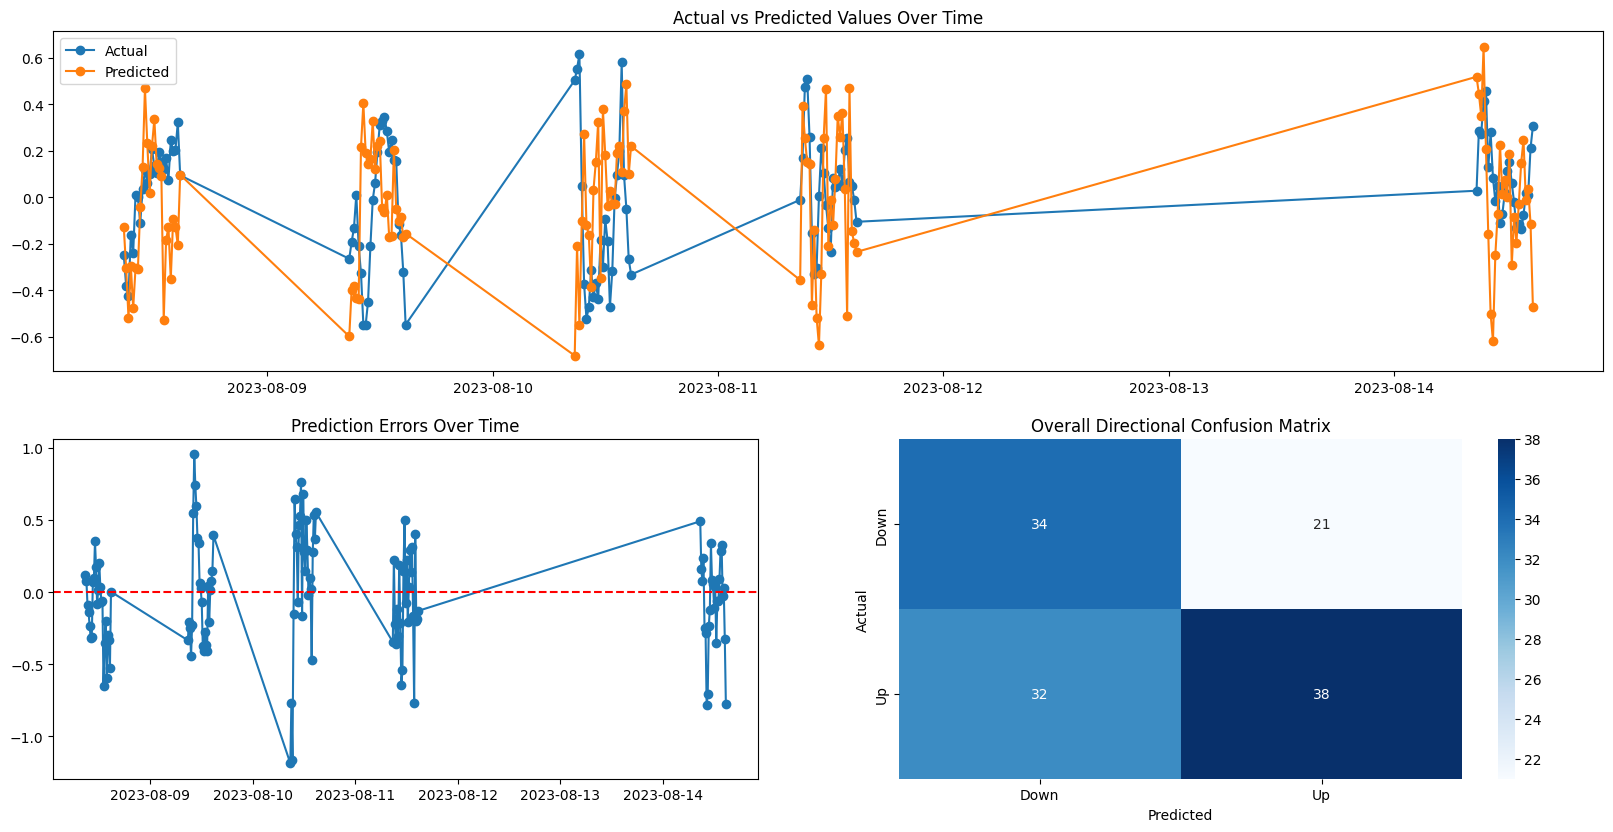

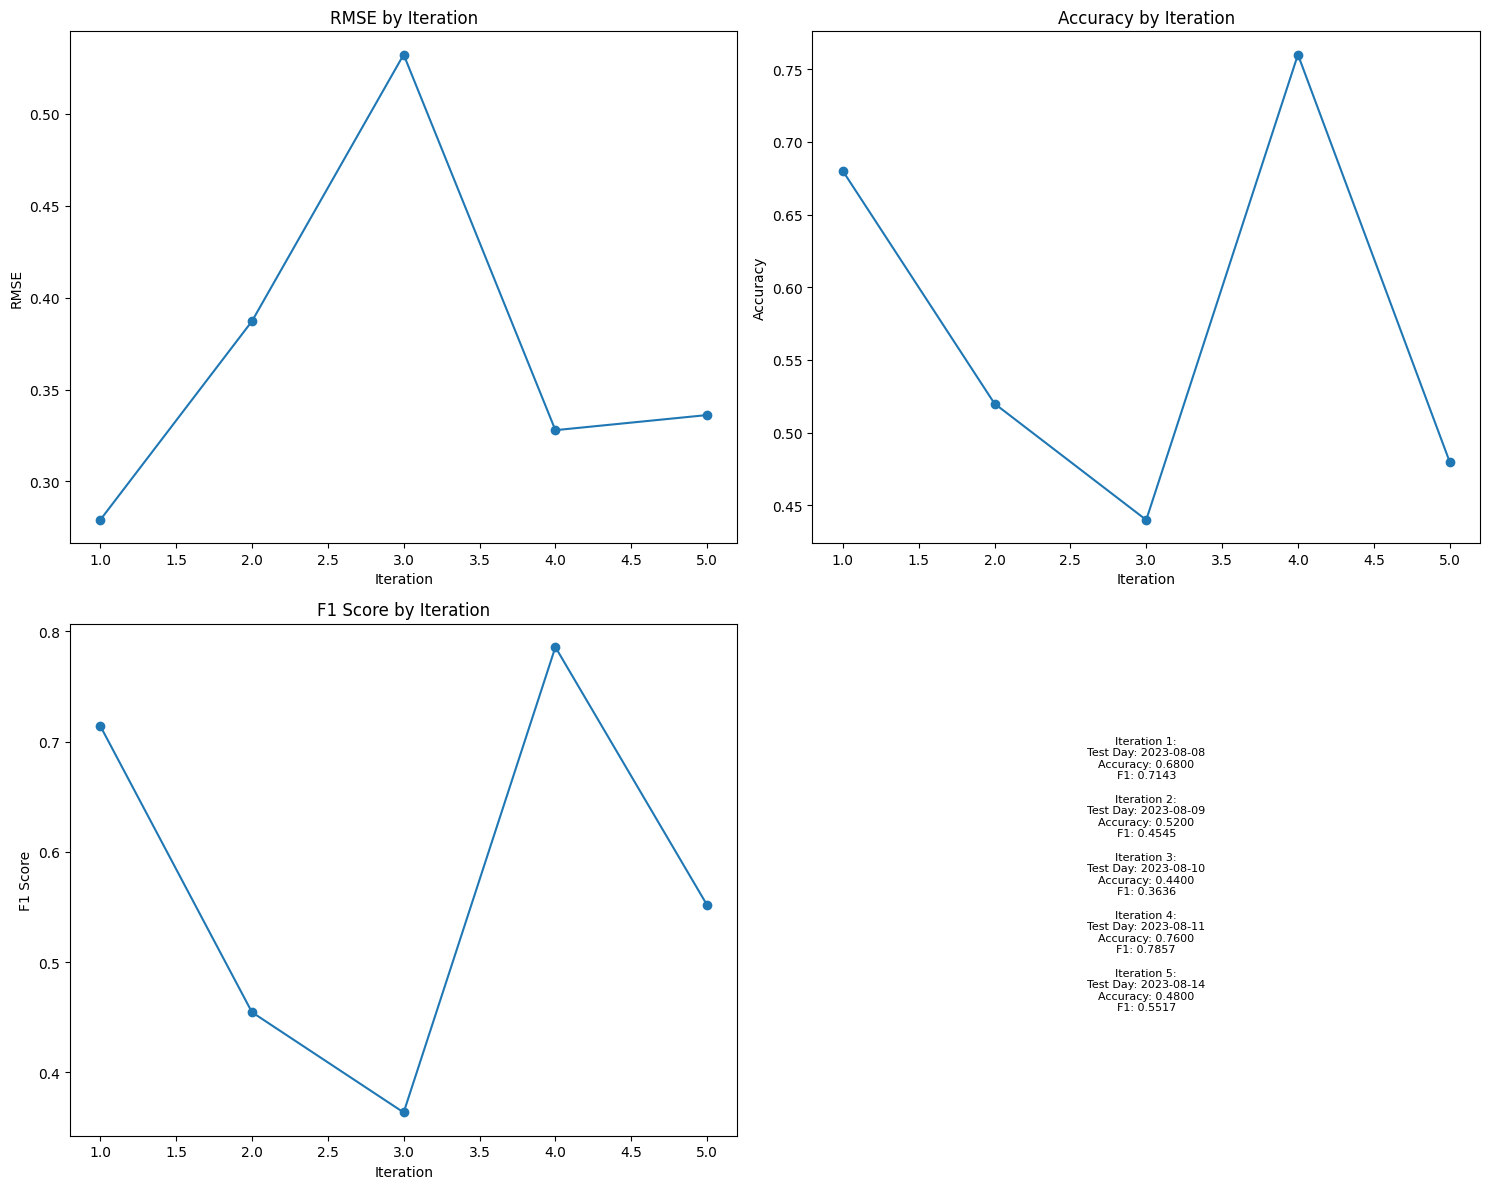

In [3]:
# Load data
df = pd.read_csv('model_data.csv', parse_dates=['Open time'])
df.set_index('Open time', inplace=True)

# Initialize transformer trainer
trainer = TransformerRollingWindowTrainer(train_days=5, test_days=1, sequence_length=1)

# Run analysis
results = trainer.run_rolling_window(df, n_iterations=5)

# Plot results
fig_main, fig_iterations = trainer.evaluate_and_plot()